Setting up the simulator

In [10]:
import pybullet as p
import pybullet_data
import time
import numpy as np
import tensorflow as tf
from tf_agents.policies import py_tf_eager_policy
import tensorflow_hub as hub
from tf_agents.trajectories import time_step as ts

In [40]:
# Initialize PyBullet
physicsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

# Load the environment
planeId = p.loadURDF("plane.urdf")

# Scale the table, cube, and robot
tableScale = 1    # Table size
cubeScale = 0.2   # Size of the cube
robotScale = 2.0  # Size of the robot

# Load the table
tableId = p.loadURDF("table/table.urdf", basePosition=[1, 0, 0], globalScaling=tableScale)

# Calculate the height at which the cube should be placed to be on top of the table
cubeHeight = cubeScale * 0.5  # Half of the cube's height
tableHeight = 1  # Assuming the table's height is 1 unit
cubePositionHeight = tableHeight + cubeHeight

# Load the cube on the table
cubeId = p.loadURDF("cube.urdf", basePosition=[1, 0, cubePositionHeight], globalScaling=cubeScale)

# Position and scale the robot
startPos = [0, 0, 0]
startOrientation = p.getQuaternionFromEuler([0, 0, 0])
robotId = p.loadURDF("franka_panda/panda.urdf", startPos, startOrientation, globalScaling=robotScale)


error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

Setting up virtual cameras for observation

In [38]:
# Function to capture images
import matplotlib.pyplot as plt
def capture_image():
    width, height = 224, 224
    view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[1, 0, 1],
                                                      distance=1,
                                                      yaw=0,
                                                      pitch=-30,
                                                      roll=0,
                                                      upAxisIndex=2)
    projection_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1.0,
                                                     nearVal=0.1, farVal=100.0)
    _, _, rgbImg, depthImg, _ = p.getCameraImage(width=width,
                                                 height=height,
                                                 viewMatrix=view_matrix,
                                                 projectionMatrix=projection_matrix)
    # dummy = np.reshape(rgbImg, (width, height, 3))
    # print(dummy)
    # return np.array(rgbImg), np.array(depthImg)
    image = np.reshape(rgbImg, (width, height, 4))
    imgplot = plt.imshow(image)
    return np.reshape(rgbImg, (width, height, 4)), np.array(depthImg)

In [20]:
#Preprocessed the observation
def preprocess_observation(rgbImg):
    processed_img = rgbImg / 255.0
    return processed_img

Load TF model checkpoints

In [5]:
# Load the pretrained model
saved_model_path = 'rt_1_x_tf_trained_for_002272480_step'
tfa_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    model_path=saved_model_path,
    load_specs_from_pbtxt=True,
    use_tf_function=True)

***Load Language Instruction***

In [6]:
# Load language model for instructions embedding
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/5')

In [7]:
def embed_instruction(instruction):
    normalized_instruction = instruction.replace('_', ' ')
    return embed([normalized_instruction])[0]

In [17]:
def resize_image(image, new_width=320, new_height=256):
    return tf.image.resize(image, [new_height, new_width])

***Running the Simulation***

(224, 224, 4)


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * TimeStep(
{'step_type': <tf.Tensor 'time_step:0' shape=(1,) dtype=int32>,
 'reward': <tf.Tensor 'time_step_1:0' shape=(1,) dtype=float32>,
 'discount': <tf.Tensor 'time_step_2:0' shape=(1,) dtype=float32>,
 'observation': {'image': <tf.Tensor 'time_step_3:0' shape=(1, 256, 320, 4) dtype=float32>,
                 'natural_language_embedding': <tf.Tensor 'time_step_4:0' shape=(1, 512) dtype=float32>,
                 'natural_language_instruction': <tf.Tensor 'time_step_5:0' shape=(1, 1) dtype=string>}})
    * {'action_tokens': <tf.Tensor 'policy_state:0' shape=(1, 15, 11, 1, 1) dtype=int32>,
 'context_image_tokens': <tf.Tensor 'policy_state_1:0' shape=(1, 15, 81, 1, 512) dtype=float32>,
 'seq_idx': <tf.Tensor 'policy_state_2:0' shape=(1, 1, 1, 1, 1) dtype=int32>}
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (3 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='discount'), observation={'image': TensorSpec(shape=(None, 256, 320, 3), dtype=tf.uint8, name='observation/image'), 'natural_language_embedding': TensorSpec(shape=(None, 512), dtype=tf.float32, name='observation/natural_language_embedding'), 'natural_language_instruction': TensorSpec(shape=(None,), dtype=tf.string, name='observation/natural_language_instruction')})
    * {'action_tokens': TensorSpec(shape=(None, 15, 11, 1, 1), dtype=tf.int32, name='action_tokens'),
 'context_image_tokens': TensorSpec(shape=(None, 15, 81, 1, 512), dtype=tf.float32, name='context_image_tokens'),
 'seq_idx': TensorSpec(shape=(None, 1, 1, 1, 1), dtype=tf.int32, name='seq_idx')}
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TimeStep(step_type=TensorSpec(shape=(None,), dtype=tf.int32, name='time_step_step_type'), reward=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step_reward'), discount=TensorSpec(shape=(None,), dtype=tf.float32, name='time_step_discount'), observation={'image': TensorSpec(shape=(None, 256, 320, 3), dtype=tf.uint8, name='time_step_observation_image'), 'natural_language_embedding': TensorSpec(shape=(None, 512), dtype=tf.float32, name='time_step_observation_natural_language_embedding'), 'natural_language_instruction': TensorSpec(shape=(None,), dtype=tf.string, name='time_step_observation_natural_language_instruction')})
    * {'action_tokens': TensorSpec(shape=(None, 15, 11, 1, 1), dtype=tf.int32, name='policy_state_action_tokens'),
 'context_image_tokens': TensorSpec(shape=(None, 15, 81, 1, 512), dtype=tf.float32, name='policy_state_context_image_tokens'),
 'seq_idx': TensorSpec(shape=(None, 1, 1, 1, 1), dtype=tf.int32, name='policy_state_seq_idx')}
    * None
  Keyword arguments: {}

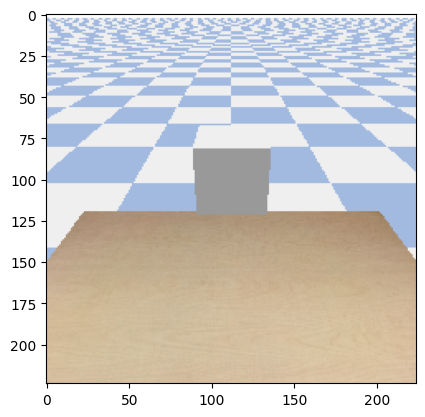

In [39]:
# Simulation loop
for i in range(1000):
    rgbImg, depthImg = capture_image()
    processed_img = preprocess_observation(rgbImg)
    print(processed_img.shape)
    resized_img = resize_image(processed_img)

    # Define the task instruction
    instruction = "Pick up the cube"
    instruction_embedding = embed_instruction(instruction)

    # Construct the observation to match the expected structure
    observation = {
        'image': resized_img,  # Make sure this is uint8 and shape (256, 320, 3)
        'natural_language_embedding': instruction_embedding,
        'natural_language_instruction': tf.constant([instruction])  # Ensure this matches expected type
    }

    # Initialize policy state if required by your model
    policy_state = {
        'action_tokens': tf.zeros([1, 15, 11, 1, 1], dtype=tf.int32),
        'context_image_tokens': tf.zeros([1, 15, 81, 1, 512], dtype=tf.float32),
        'seq_idx': tf.zeros([1, 1, 1, 1, 1], dtype=tf.int32)
    }

    # Obtain the action from the policy
    tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))
    policy_step = tfa_policy.action(tfa_time_step, policy_state=policy_state)
    action = policy_step.action

    # Apply the action to the robot in the simulation as per your setup
    # e.g., p.setJointMotorControlArray(...) for joint actions

    p.stepSimulation()
    time.sleep(1./240.)

p.disconnect()